In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import random
import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.data import Data


from torch_geometric.data import DataLoader,InMemoryDataset, download_url

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from MyDatasetLoader import MyDatasetLoader

In [110]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [78]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Add self-loops to the adjacency matrix.
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)

        # Transform node feature matrix.
        self_x = self.lin_self(x)
        #x = self.lin(x)

        return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x))

    def message(self, x_i, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]

        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

In [243]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)
    print(max(dataset.num_node_features, 1), dataset.num_classes) 
    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        k=0
        for batch in loader:
            #print(batch)
            k=k+1
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
           
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
           
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model



In [244]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y
        if model.task == 'node':
            mask = data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]

        correct += pred.eq(label).sum().item()
    
   
    total = 0
    for data in loader.dataset:
        total += torch.sum(data.test_mask).item()
    if total==0:
        return 0
    
    return correct / total

In [272]:
dataset=MyOwnDataset(root='./cora')
#print(torch.tensor(dataset[0].x,dtype=torch.float32))
test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)




Processing...
Done!
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [273]:

#print(dataset.num_node_features)
print(dataset[0].edge_index)
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
model = train(dataset, 'node', writer)


tensor([[ 163,  402,  163,  ..., 1887,  837, 1686],
        [ 402,  163,  659,  ..., 1902, 1686,  837]])
1433 7
Epoch 0. Loss: 1.9604. Test accuracy: 0.3641
Epoch 10. Loss: 0.5750. Test accuracy: 0.8130
Epoch 20. Loss: 0.3346. Test accuracy: 0.8229
Epoch 30. Loss: 0.2284. Test accuracy: 0.8315
Epoch 40. Loss: 0.1761. Test accuracy: 0.8327
Epoch 50. Loss: 0.1576. Test accuracy: 0.8180
Epoch 60. Loss: 0.1387. Test accuracy: 0.8216
Epoch 70. Loss: 0.1265. Test accuracy: 0.8167
Epoch 80. Loss: 0.1226. Test accuracy: 0.8155
Epoch 90. Loss: 0.0834. Test accuracy: 0.8229
Epoch 100. Loss: 0.1020. Test accuracy: 0.8204
Epoch 110. Loss: 0.0824. Test accuracy: 0.8130
Epoch 120. Loss: 0.0785. Test accuracy: 0.8180
Epoch 130. Loss: 0.0756. Test accuracy: 0.8167
Epoch 140. Loss: 0.0910. Test accuracy: 0.8180
Epoch 150. Loss: 0.0744. Test accuracy: 0.8241
Epoch 160. Loss: 0.0788. Test accuracy: 0.8229
Epoch 170. Loss: 0.0722. Test accuracy: 0.8093
Epoch 180. Loss: 0.0616. Test accuracy: 0.8216
Epoch 

C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\damia\anaconda3\envs\tesiNew\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


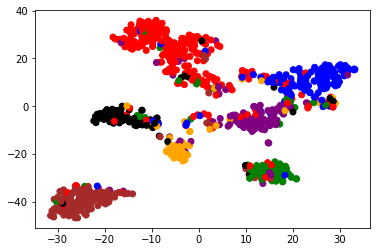

In [298]:
color_list = ["red", "orange", "green", "blue", "purple", "brown","black","gray","yellow"]
loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
batch=dataset[0]
#for batch in dataset[0]:
emb, pred = model(batch)
pred = pred.argmax(dim=1)
emb=emb[batch.test_mask]
embs.append(emb)
yl=batch.y[batch.test_mask]
colors += [color_list[y] for y in yl]
embs = torch.cat(embs, dim=0)
xs, ys = zip(*TSNE(init='pca',random_state=33).fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)

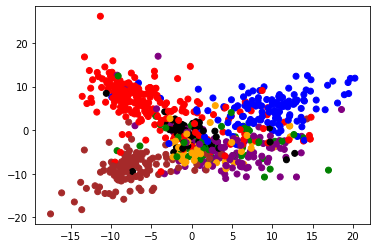

In [285]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embs.detach().numpy())
xs,ys=zip(*principalComponents)
#plt.figure(figsize = (20, 20))
plt.scatter(xs, ys, color=colors)
plt.savefig('foo.png')